In [1]:
import ete3
import random
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import pandas as pd
import scipy as scp
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import os
import subprocess
from itertools import product, combinations
import community
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor as hr, LinearRegression as lr

%cd /work/clusterEvo/new_tests/set5

/work/clusterEvo/new_tests/set5


In [2]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [3]:
# random.seed(12345)
fixed_tree = ete3.Tree()
tree_size  = 50
taxa       = []
loop_count = 0

if tree_size <= 25:
    for chr_number in range(97, 97+tree_size):
        taxa.append(chr(chr_number))
else:
    while len(taxa) < tree_size: 
        loop_count += 1
        for chr_number in range(97, 123):
            taxa.append('%s%i' %(chr(chr_number), loop_count))
    taxa = taxa[:tree_size]
            
fixed_tree.populate(size=tree_size, names_library=taxa, random_branches=True)
for node in fixed_tree.traverse():
    node.img_style["size"] = 0
fixed_tree.dist = 0.1

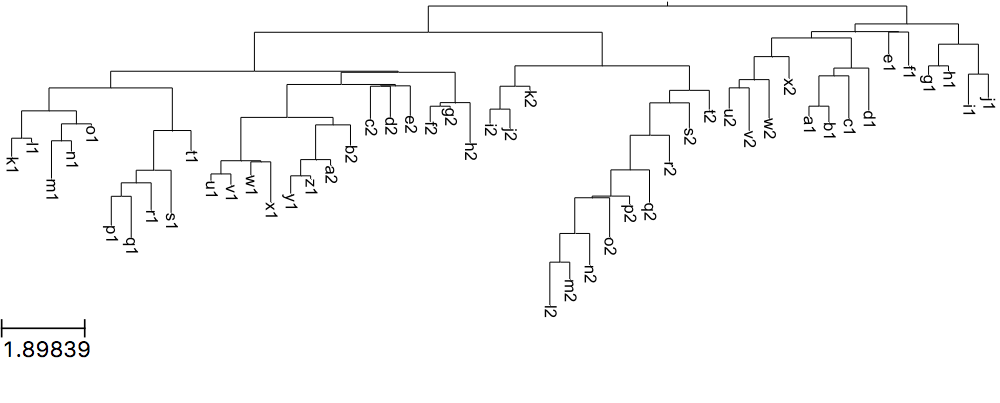

In [4]:
ts = ete3.TreeStyle()
ts.rotation = 90
fixed_tree.render("%%inline", tree_style=ts, w=1000)

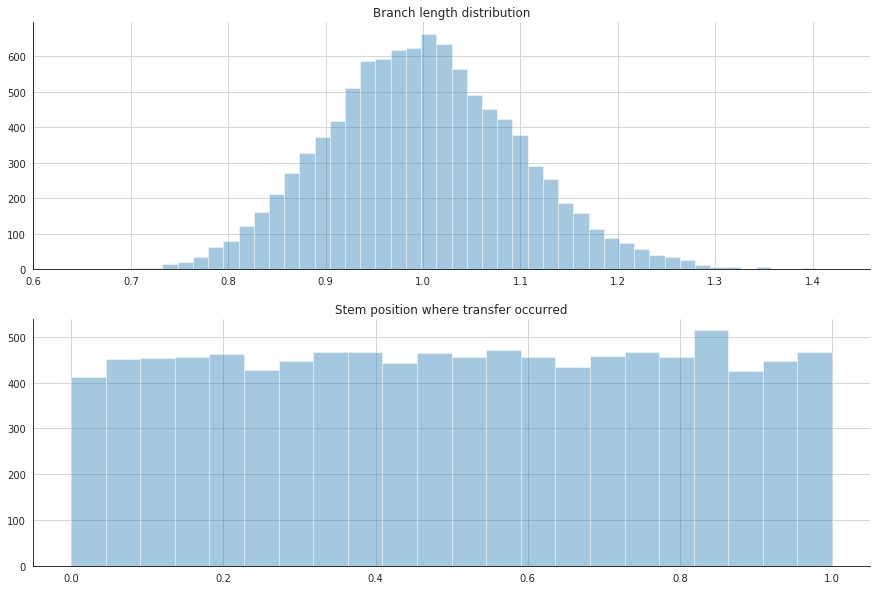

In [5]:
with pm.Model() as model:
#    alpha = 1/np.mean([node.dist for node in fixed_tree.traverse()
#                       if not node.is_root()])
    br_length_scale   = pm.Gamma('br_length_scale', 100, 100)
    point_of_transfer = pm.Uniform('point_of_transfer', lower=0, upper=1)

with sns.axes_style('whitegrid', rc={'axes.spines.top':   False,
                                 'axes.spines.right': False,
                                 'axes.edgecolor': 'k'}):
    fig, axs = plt.subplots(figsize=(15, 10), nrows=2)
    sample   = br_length_scale.random(size=10000)
    sns.distplot(sample, kde=False, ax=axs[0])
    axs[0].set_title('Branch length distribution')
    sample   = point_of_transfer.random(size=10000)
    sns.distplot(sample, kde=False, ax=axs[1])
    axs[1].set_title('Stem position where transfer occurred');

In [6]:
ts = ete3.TreeStyle()
ts.show_branch_length = True

if not os.path.isdir('trees'):
    os.mkdir('trees')
    
# seed = 12345
# np.random.seed(seed)
# random.seed(   seed)
tree         = fixed_tree.copy()
topologies   = [tree.copy()]
topology_ids = set(tree.get_topology_id())
with cd('trees'):
    tree.render(file_name ="tree_%i.png" % len(topologies), 
                dpi       =100, 
                w         =500, 
                units     ='px', 
                tree_style=ts)

while len(topologies) < 10:
    starting_tree = tree.copy()
    
    pruned_node    = random.choice([node for node in tree.traverse()
                                    if tree.get_distance(node, topology_only=True) > 0]).copy()
    pruned_node.dist *= br_length_scale.random()
    
    tree.prune(set(taxa).difference(pruned_node.get_leaf_names()), preserve_branch_length=True)

    source = random.choice([node for node in tree.traverse()
                            if not node.is_root()])

    source.add_sister(pruned_node)
    tree.resolve_polytomy()

    topology_id = tree.get_topology_id()
    if topology_id in topology_ids:
        tree = starting_tree.copy()
        continue
    
    if pruned_node.is_leaf():
        recipient = tree.get_leaves_by_name(pruned_node.name)[0]
    else:
        recipient = tree.get_common_ancestor(pruned_node.get_leaf_names())
    parent    = recipient.get_ancestors()[0]
    donor     = recipient.get_sisters()[0]

    proportion  = point_of_transfer.random()
    parent.dist = donor.dist * proportion
    donor.dist -= donor.get_ancestors()[0].dist

    parent.img_style['size']       = 0
    donor.img_style['size'   ]     = 5
    donor.img_style['fgcolor']     = 'red'
    recipient.img_style['size'   ] = 5
    recipient.img_style['fgcolor'] = 'blue'
    
    topology_ids.add(topology_id)
    topologies.append(tree.copy())
    with cd('trees'):
        tree.render(file_name ="tree_%i.png" % len(topologies), 
                    dpi       =100, 
                    w         =500, 
                    units     ='px', 
                    tree_style=ts)

    donor.img_style['size']        = 0
    recipient.img_style['size']    = 0

In [7]:
indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - site-rate project                               //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   5150

[MODEL] model1   [submodel]  LG                         //   LG
                 [rates]     0 0.8025 4                //   pinv=0, alpha=1.3, discrete gamma categories=4
//                 [statefreq]
//                    0.0790   0.0843   0.0346   0.0392   // list of 20 numbers
//                    0.0055   0.0293   0.0535   0.0956   // A R N D C
//                    0.0217   0.0704   0.0699   0.1008   // Q E G H I
//                    0.0253   0.0280   0.0415   0.0519   // L K M F P
//                    0.0516   0.0065   0.0217   0.0898   // S T W Y V
//                 [indelmodel]   POW  1.7 500 // Power law insertion/deletion length distribution (a=1.7)
//                 [indelrate]    0.1
'''

indelible_tree_exert      = '[TREE]       {tree_name}  {newick}\n'
indelible_partition_exert = '[PARTITIONS] {partition_name} [{tree_name} model1 1000]\n'
indelible_evolve_exert    = '             {partition_name}  1   {tree_name}\n'

for count, tree in enumerate(topologies, 1):
    indelible_conf += indelible_tree_exert.format(tree_name='tree_%i'  % count,
                                                  newick   = tree.write(format=5, dist_formatter='%.10f'))
indelible_conf += '\n'
    
for count, tree in enumerate(topologies, 1):
    indelible_conf += indelible_partition_exert.format(partition_name='partition_%i'  % count,
                                                       tree_name     ='tree_%i'       % count)
indelible_conf += '\n'

indelible_conf += '[EVOLVE]     {partition_name}  1   {tree_name}\n'.format(
    partition_name='partition_1',
    tree_name     ='tree_1')
for count, tree in enumerate(topologies[1:], 2):
    indelible_conf += indelible_evolve_exert.format(partition_name='partition_%i'  % count,
                                                    tree_name     ='tree_%i'       % count)

with open('control.txt', 'w') as out:
    out.write(indelible_conf)

In [8]:
subprocess.call(['/work/site_rate/indelible/INDELibleV1.03/bin/indelible_1.03_OSX_intel'])

0

In [9]:
if not os.path.isdir('alignments'):
    os.mkdir('alignments')

for count, tree in enumerate(topologies, 1):
    tree.write(outfile='trees/tree_%i.nwk' % count, format=5, dist_formatter='%.10f')
    shutil.copy('tree_%i_True.phy' % count, 'alignments/tree_%i.phy' % count)